In [125]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

In [126]:
dataset = pd.read_csv('GPUs.csv', skiprows=1, sep=';')

In [127]:
dataset.head(30)

,Nazwa,Koszt,Wydajnosc,TDP,Ocena
0,Nvidia RTX 3060-Ti,2109,132.0,220,99
1,Nvidia RTX 3070,2383,154.0,220,99
2,Nvidia RTX 3050,1408,71.7,130,96
3,Nvidia GTX 1660S,1043,70.5,125,94
4,Nvidia RTX 3080,4266,206.0,320,91
5,Nvidia RTX 4090,9699,422.0,450,90
6,Nvidia RTX 2060,1493,88.6,175,87
7,Nvidia RTX 4080,7049,331.0,320,66
8,Nvidia RTX 3090-Ti,6499,266.0,450,60
9,Nvidia RTX 3090,5767,233.0,350,71


In [128]:
dataset.describe()

,Koszt,Wydajnosc,TDP,Ocena
count,21.000000,21.000000,21.000000,21.000000
mean,4087.809524,167.376190,271.000000,70.000000
std,2451.496352,90.338192,89.145948,17.997222
min,1043.000000,70.500000,125.000000,50.000000
25%,2109.000000,96.200000,220.000000,57.000000
50%,3599.000000,147.000000,250.000000,60.000000
75%,6162.000000,206.000000,320.000000,90.000000
max,9699.000000,422.000000,450.000000,99.000000


# Promethe

In [129]:
# Preference funcions

def pref_v_shape(d, q, p):
    if d > p:
        return 1
    elif d <= q:
        return 0
    else:
        return (d - q) / (p - q)

In [130]:
def comprehensive_preference_index(item1, item2, pref_info):
    val = 0.0
    for i in range(len(pref_info)):
        g = pref_info.iloc[i].name
        w = pref_info.iloc[i]["w"]
        q = pref_info.iloc[i]["q"]
        p = pref_info.iloc[i]["p"]
        a = item1[g]
        b = item2[g]
        d = a - b if pref_info.iloc[i]["cost_or_gain"] == "g" else b - a
        pref = pref_info.iloc[i]["pref_func"](d, q, p)
        val += pref * w
    
    val /= pref_info["w"].sum()

    return val 

In [131]:
pref_info = pd.DataFrame({
    "g": ["Koszt", "Wydajnosc", "TDP", "Ocena"],
    "q": [100, 15, 10, 5],
    "p": [300, 40, 30, 30],
    "w": [3, 4, 1, 2],
    "cost_or_gain": ["c", "g", "c", "g"],
    "pref_func": [pref_v_shape]*4
})

pref_info = pref_info.set_index("g")

In [132]:
pref_info

,q,p,w,cost_or_gain,pref_func
g,,,,,
Koszt,100,300,3,c,<function pref_v_shape at 0x000001F4B9077310>
Wydajnosc,15,40,4,g,<function pref_v_shape at 0x000001F4B9077310>
TDP,10,30,1,c,<function pref_v_shape at 0x000001F4B9077310>
Ocena,5,30,2,g,<function pref_v_shape at 0x000001F4B9077310>


In [133]:
pref_info.iloc[0] 

q                                                         100
p                                                         300
w                                                           3
cost_or_gain                                                c
pref_func       <function pref_v_shape at 0x000001F4B9077310>
Name: Koszt, dtype: object

In [134]:
pref_info.loc["Koszt"]

q                                                         100
p                                                         300
w                                                           3
cost_or_gain                                                c
pref_func       <function pref_v_shape at 0x000001F4B9077310>
Name: Koszt, dtype: object

In [135]:
comprehensive_preference_index(dataset.iloc[0], dataset.iloc[1], pref_info)

0.261

In [136]:
comp_table = []

for i in range(len(dataset)):
    item1 = dataset.iloc[i]
    row = []
    for j in range(len(dataset)):
        item2 = dataset.iloc[j]
        result = comprehensive_preference_index(item1, item2, pref_info)
        row.append(result)
    comp_table.append(row)

comp_df = pd.DataFrame(comp_table)
flow_plus = comp_df.sum(axis=1)
flow_minus = comp_df.sum(axis=0)
flow = flow_plus - flow_minus
comp_df['flow+'] = flow_plus
comp_df['flow-'] = flow_minus
comp_df['flow'] = flow

In [137]:
comp_df.sort_values("flow", ascending=False)

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,flow+,flow-,flow
1,0.112,0.000,0.4000,0.4000,0.424,0.432,0.4560,0.600,0.600,0.584,...,0.900,0.6000,0.6000,0.600,1.000,0.9000,0.600,11.8320,5.0730,6.7590
0,0.000,0.261,0.4000,0.4000,0.424,0.432,0.4560,0.600,0.600,0.584,...,0.580,0.5776,0.6000,0.600,0.648,0.8328,0.600,10.9954,5.3070,5.6884
3,0.400,0.400,0.3000,0.0000,0.400,0.400,0.4160,0.584,0.600,0.544,...,0.600,0.6000,0.6000,0.600,0.600,0.6000,0.600,10.6440,6.3472,4.2968
4,0.400,0.400,0.4000,0.4000,0.000,0.400,0.4000,0.460,0.600,0.520,...,0.600,0.6000,0.6000,0.600,0.600,0.6000,0.605,10.5650,6.7840,3.7810
2,0.400,0.400,0.0000,0.0000,0.400,0.408,0.1320,0.600,0.600,0.560,...,0.600,0.6000,0.5265,0.600,0.600,0.6000,0.600,10.0265,6.5896,3.4369
6,0.400,0.400,0.0304,0.0496,0.400,0.400,0.0000,0.528,0.576,0.488,...,0.584,0.6000,0.3990,0.576,0.600,0.5000,0.600,9.4590,6.1032,3.3558
5,0.400,0.400,0.4000,0.4000,0.400,0.000,0.4000,0.552,0.600,0.512,...,0.600,0.6000,0.6000,0.600,0.600,0.6000,0.600,10.6400,7.9720,2.6680
11,0.320,0.000,0.4000,0.4000,0.400,0.400,0.4000,0.400,0.400,0.400,...,0.400,0.4480,0.4640,0.400,0.748,0.4320,0.440,8.2400,7.0160,1.2240
9,0.400,0.400,0.4000,0.4000,0.192,0.400,0.4000,0.300,0.448,0.000,...,0.456,0.5120,0.5280,0.348,0.512,0.4960,0.804,9.1120,7.9050,1.2070
7,0.400,0.400,0.4000,0.4000,0.400,0.400,0.4000,0.000,0.508,0.500,...,0.416,0.4720,0.4880,0.508,0.472,0.4560,0.789,9.0810,8.3240,0.7570


### Promethe I

In [138]:
rank_plus = comp_df.sort_values("flow+", ascending=False)[['flow+', 'flow-', 'flow']]

In [139]:
rank_minus = comp_df.sort_values("flow-", ascending=True)[['flow+', 'flow-', 'flow']]

In [140]:
rank_table = []

for i in range(len(dataset)):
    i1_f_p = comp_df['flow+'][i]
    i1_f_m = comp_df['flow-'][i]
    row = []
    for j in range(len(dataset)):
        i2_f_p = comp_df['flow+'][j]
        i2_f_m = comp_df['flow-'][j]

        result = '' 
        if (i1_f_p > i2_f_p and i1_f_m < i2_f_m) or (i1_f_p == i2_f_p and i1_f_m < i2_f_m) or (i1_f_p > i2_f_p and i1_f_m == i2_f_m):
            result = 'P' 
        elif i1_f_p == i2_f_p and i1_f_m == i2_f_m:
            result = 'I' 
        elif (i1_f_p > i2_f_p and i1_f_m > i2_f_m) or (i1_f_p < i2_f_p and i1_f_m < i2_f_m):
            result = 'R'
        row.append(result)
    rank_table.append(row)

rank_df = pd.DataFrame(rank_table)

In [145]:
rank_df

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,I,,P,P,P,P,P,P,P,P,...,P,P,P,P,P,P,P,P,P,P
1,P,I,P,P,P,P,P,P,P,P,...,P,P,P,P,P,P,P,P,P,P
2,,,I,,R,R,R,P,P,P,...,P,P,P,P,P,P,P,P,P,P
3,,,P,I,P,P,R,P,P,P,...,P,P,P,P,P,P,P,P,P,P
4,,,R,,I,R,R,P,P,P,...,P,P,P,P,P,P,P,P,P,P
5,,,R,,R,I,R,P,P,R,...,R,P,P,P,P,P,P,P,P,P
6,,,R,R,R,R,I,P,P,P,...,P,P,P,P,P,P,P,P,P,P
7,,,,,,,,I,P,,...,R,P,P,P,P,P,P,P,P,P
8,,,,,,,,,I,,...,,P,P,R,R,R,R,P,R,P
9,,,,,,R,,P,P,I,...,R,P,P,P,P,P,P,P,P,P


In [142]:
rank_df_copy = rank_df.copy()
rank = []
while rank_df_copy.shape[0] != 0:
    rank_place = []
    best_item_idx = (rank_df_copy == 'P').sum(axis=1).idxmax()
    rank_place.append(best_item_idx)
    rank_df_copy = rank_df_copy.drop(best_item_idx)
    indiferent = rank_df_copy.index[rank_df_copy[best_item_idx] == 'R'].tolist()
    rank_place.extend(indiferent)
    rank_df_copy = rank_df_copy.drop(indiferent)

    rank.append(rank_place)

print(rank)

[[1], [0], [3, 6], [2, 4, 5], [9, 11], [7], [16, 8, 14, 17], [15, 10, 12], [13, 19], [18, 20]]


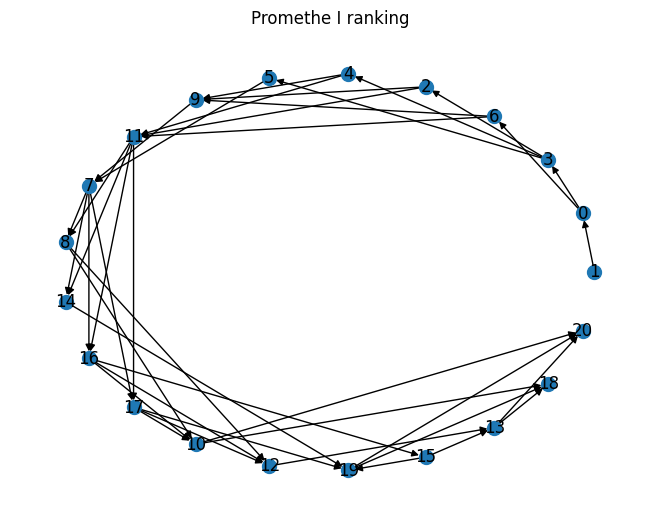

In [169]:
def draw_rank(rank_df):
    G = nx.DiGraph()

    for i in comp_df.sort_values("flow", ascending=False).index.tolist():
        G.add_node(i)
        for j in range(len(rank_df)):
            if rank_df[j][i] == 'P' and (rank_df[j][rank_df.index[rank_df.loc[i]=='P']] == 'P').sum() == 0:
                G.add_edge(i, j)

    # Draw as planar graph
    pos = nx.circular_layout(G)
    nx.draw(G, pos, with_labels=True, node_size=100)
    plt.title("Promethe I ranking")
    plt.show()


draw_rank(rank_df)

##### 3 jest nieporównywalne z 6, ale 6 jest też nieporównywalne z 2,4 które są gorsze od 3, gdzie ma być 6?

### Promethe II

In [143]:
comp_df.sort_values("flow", ascending=False)[['flow+', 'flow-', 'flow']]

,flow+,flow-,flow
1,11.8320,5.0730,6.7590
0,10.9954,5.3070,5.6884
3,10.6440,6.3472,4.2968
4,10.5650,6.7840,3.7810
2,10.0265,6.5896,3.4369
6,9.4590,6.1032,3.3558
5,10.6400,7.9720,2.6680
11,8.2400,7.0160,1.2240
9,9.1120,7.9050,1.2070
7,9.0810,8.3240,0.7570
